In [4]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt 
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [10,5]
plt.style.use('ggplot')  

This notebook aims to apply the parametric Value at Risk technique, discussing its conditions and limitations. The topics will be discussed in the following order:
* Introduction and explanation of the method;
* Risk assessment of a stock using the real price time series of the asset;
* Risk assessment of a stock portfolio using the real price time series of the assets;
* Method validation using a sliding window and comparison with real outcomes

# Value at Risk(VaR)

### Introduction to Value as Risk

The Value at Risk (VaR) represents the maximum expected loss of a stock, set of stocks, or index with significance $\alpha$. VaR answers the question 'How much can I lose with $\alpha$ probability over a predefined time horizon?', meaning that after observing an asset for a certain period, how much of the capital would I lose if an event of probability $\alpha$ occurred.

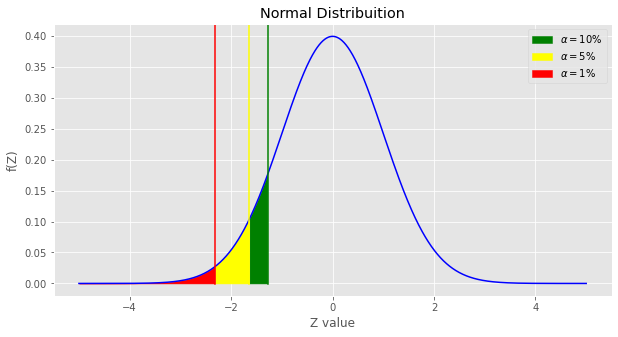

In [5]:
# Parameters and Data
mean = 0
std = 1
x = np.linspace(-5, 5, 1000)
y = (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-(x - mean)**2 / (2 * std**2))

# Creating graph
plt.plot(x, y, color='blue')

# Filling area 
plt.fill_between(x, y, where=((x < -1.28155)&(x >-1.64485)), color='green', alpha=1,label = r'$\alpha = 10$%')
plt.fill_between(x, y, where=((x <-1.64485)&(x >-2.32635 )), color='yellow', alpha=1,label = r'$\alpha = 5$%')
plt.fill_between(x, y, where=((x < -2.32635)), color='red', alpha=1, label = r'$\alpha = 1$%')

plt.axvline(x = -1.28155, color = 'green',ymin=0.0425)
#plt.text(-1.18155,0.4,'Z=-1.18155')
plt.axvline(x = -1.64485, color = 'yellow',ymin=0.0425)
#plt.text(-1.64485,0.35,'Z=-1.64485')
plt.axvline(x = -2.32635, color = 'red',ymin=0.0425)
#plt.text(-2.32635,0.3,'Z=-2.32635')


plt.xlabel('Z value')
plt.ylabel('f(Z)')
plt.title('Normal Distribuition')
plt.legend()

plt.grid(True)
plt.show()

## Stock Risk Assessment

In [12]:
start_date = dt.datetime(2022, 1, 1)# Look for other windows of 2y (like 2017)
ticker = yf.Ticker("ELET3.SA")
serie = ticker.history(period="2y",start=start_date)
serie.drop(serie.loc[serie['Open']==0].index,inplace=True) # Droping 0 values for stock price
data_series[f'{stock}'] = serie['Open'].values

In [14]:
data_series.describe()

,ELET3.SA
count,503.000000
mean,39.118400
std,4.819836
min,28.656190
25%,34.910000
50%,39.180000
75%,42.781346
max,50.968021


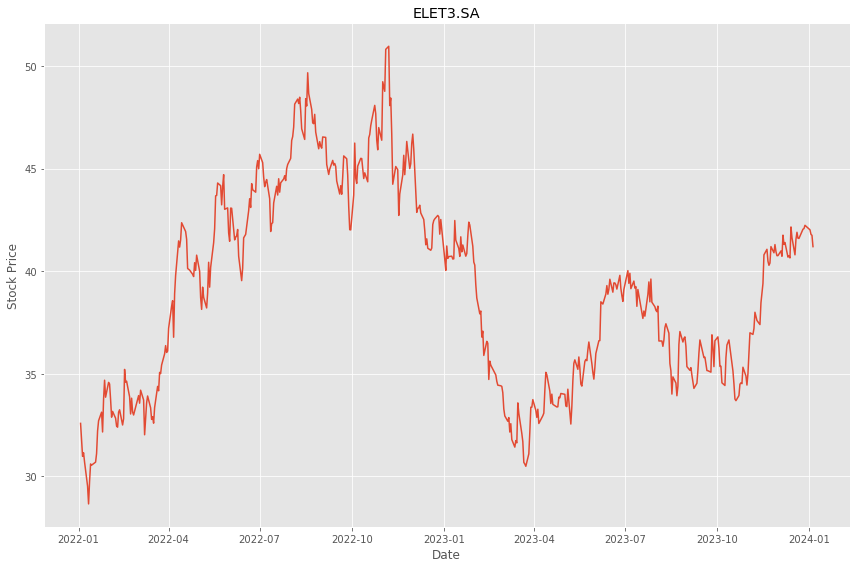

In [13]:
fig = plt.figure(figsize=(12,8))
plt.title('ELET3.SA')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.plot(serie.index[0:-1],data_series['ELET3.SA'].values[0:-1])
plt.tight_layout()

Text(0.5, 1.0, 'Daily Return Distribution')

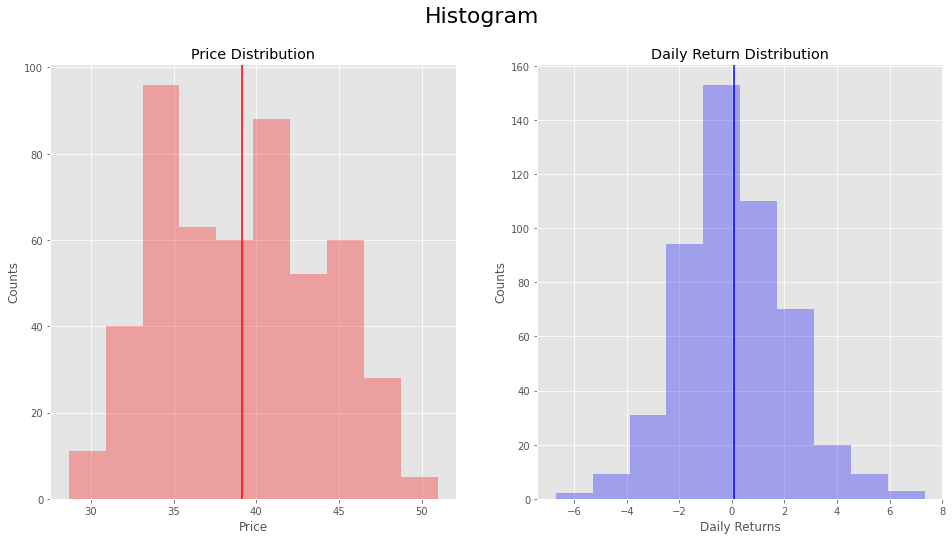

In [16]:
Price = data_series['ELET3.SA'].values
Daily_return = data_series['ELET3.SA'].pct_change().values[1:-1]*100


fig, axs = plt.subplots(1,2,figsize = (16,8))

plt.suptitle('Histogram',fontsize = 22)
axs[0].hist(Price, bins = 'sturges', alpha = 0.3,color = 'red')
axs[0].axvline(Price.mean(),color = 'red')
axs[0].set_xlabel('Price')
axs[0].set_ylabel('Counts')
axs[0].set_title('Price Distribution')

##
axs[1].hist(Daily_return, bins = 'sturges', alpha = 0.3,color = 'blue')
axs[1].axvline(Daily_return.mean(),color = 'blue')
axs[1].set_xlabel('Daily Returns')
axs[1].set_ylabel('Counts')
axs[1].set_title('Daily Return Distribution')


## Portifolio Risk Assessment

This section is to apply the method to a Portifolio, using the set of stocks in the Electric Power Index(IEE) as Stock Portifolio. The stocks in the index at 10/01/2023 are:
* ELET3
* EQLT3
* TRPL4
* AESB3
* COCE5
* ENGI11
* CPFE3
* NEOE3
* CMIG4
* ALUP11

In [49]:
start_date = dt.datetime(2022, 1, 1)# Look for other windows of 2y (like 2017)
data_series = pd.DataFrame()
#stocks = ['ELET3','EQLT3','TRPL4','AESB3','COCE5','ENGI11','CPFE3','NEOE3','CMIG4','ALUP11']

stocks = ['AESB3', 'ALUP11','AURE3','CMIG4','COCE5','CPLE6','CPFE3','ELET3','ENGI11','ENEV3','EGIE3','EQTL3','NEOE3','SRNA3','TAEE11','TRPL4']
partitions = [6.203 , 6.179 , 6.260 , 6.609 , 5.946 , 6.157 , 6.185 , 6.098 , 6.392 , 6.066 , 6.115 , 6.116 , 6.559 , 6.376 , 6.296 , 6.443] 
for i in range(0,len(stocks)):
    stock = stocks[i]
    weight = partitions[i]
    print(stock)
    ticker = yf.Ticker(stock+'.SA')
    serie = ticker.history(period="2y",start=start_date)
    serie.drop(serie.loc[serie['Open']==0].index,inplace=True) # Droping 0 values for stock price
    if(len(serie['Open'].values) != 0 ):
        data_series[f'{stock}'] = weight*serie['Open']/100



AESB3
ALUP11
AURE3
CMIG4
COCE5
CPLE6
CPFE3
ELET3
ENGI11
ENEV3
EGIE3
EQTL3
NEOE3
SRNA3
TAEE11
TRPL4


In [35]:
start_date = dt.datetime(2022, 1, 1)
stock = ['EQLT3']
A = yf.Ticker(stock[0]+'.SA')
A = A.history(period="2y",start=start_date)
A.drop(A.loc[A['Open']==0].index,inplace=True)
A['Open']#.plot()

- EQLT3.SA: No data found, symbol may be delisted


Series([], Name: Open, dtype: float64)

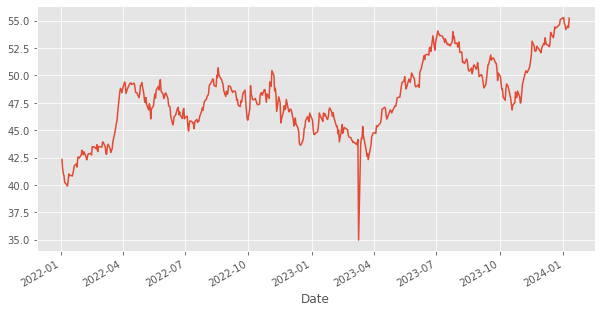

In [51]:
data_series['Total'] = data_series.sum(axis=1)
data_series['Total'].plot()

In [52]:
data_series.loc[data_series['Total']<38]

,AESB3,ALUP11,AURE3,CMIG4,COCE5,CPLE6,CPFE3,ELET3,ENGI11,ENEV3,EGIE3,EQTL3,NEOE3,SRNA3,TAEE11,TRPL4,Total
Date,,,,,,,,,,,,,,,,,
2023-03-10,0.639529,1.524466,0.753007,0.617152,2.482843,0.400678,1.730862,1.938732,NaN,0.720641,2.356316,1.57642,0.88161,0.568102,NaN,1.291951,34.964621


In [54]:
data_series.isna()

,AESB3,ALUP11,AURE3,CMIG4,COCE5,CPLE6,CPFE3,ELET3,ENGI11,ENEV3,EGIE3,EQTL3,NEOE3,SRNA3,TAEE11,TRPL4,Total
Date,,,,,,,,,,,,,,,,,
2022-01-03,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2022-01-04,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2022-01-05,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2022-01-06,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2022-01-07,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-04,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2024-01-05,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2024-01-08,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


## Validation